In [4]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

# EDA (exploring data analysis)

In [5]:
gold = pd.read_csv('data/gold_price_data.csv')
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')
gold

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [6]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


In [7]:
gold.describe

<bound method NDFrame.describe of             Date    Value
0     1970-01-01    35.20
1     1970-04-01    35.10
2     1970-07-01    35.40
3     1970-10-01    36.20
4     1971-01-01    37.40
...          ...      ...
10782 2020-03-09  1672.50
10783 2020-03-10  1655.70
10784 2020-03-11  1653.75
10785 2020-03-12  1570.70
10786 2020-03-13  1562.80

[10787 rows x 2 columns]>

In [12]:
print(gold.to_dict())

{'Date': {0: Timestamp('1970-01-01 00:00:00'), 1: Timestamp('1970-04-01 00:00:00'), 2: Timestamp('1970-07-01 00:00:00'), 3: Timestamp('1970-10-01 00:00:00'), 4: Timestamp('1971-01-01 00:00:00'), 5: Timestamp('1971-04-01 00:00:00'), 6: Timestamp('1971-07-01 00:00:00'), 7: Timestamp('1971-10-01 00:00:00'), 8: Timestamp('1972-01-03 00:00:00'), 9: Timestamp('1972-04-03 00:00:00'), 10: Timestamp('1972-07-03 00:00:00'), 11: Timestamp('1972-10-02 00:00:00'), 12: Timestamp('1973-01-01 00:00:00'), 13: Timestamp('1973-04-02 00:00:00'), 14: Timestamp('1973-07-02 00:00:00'), 15: Timestamp('1973-10-01 00:00:00'), 16: Timestamp('1974-01-01 00:00:00'), 17: Timestamp('1974-04-01 00:00:00'), 18: Timestamp('1974-07-01 00:00:00'), 19: Timestamp('1974-10-01 00:00:00'), 20: Timestamp('1975-01-01 00:00:00'), 21: Timestamp('1975-04-01 00:00:00'), 22: Timestamp('1975-07-01 00:00:00'), 23: Timestamp('1975-10-01 00:00:00'), 24: Timestamp('1976-01-01 00:00:00'), 25: Timestamp('1976-04-01 00:00:00'), 26: Timestam

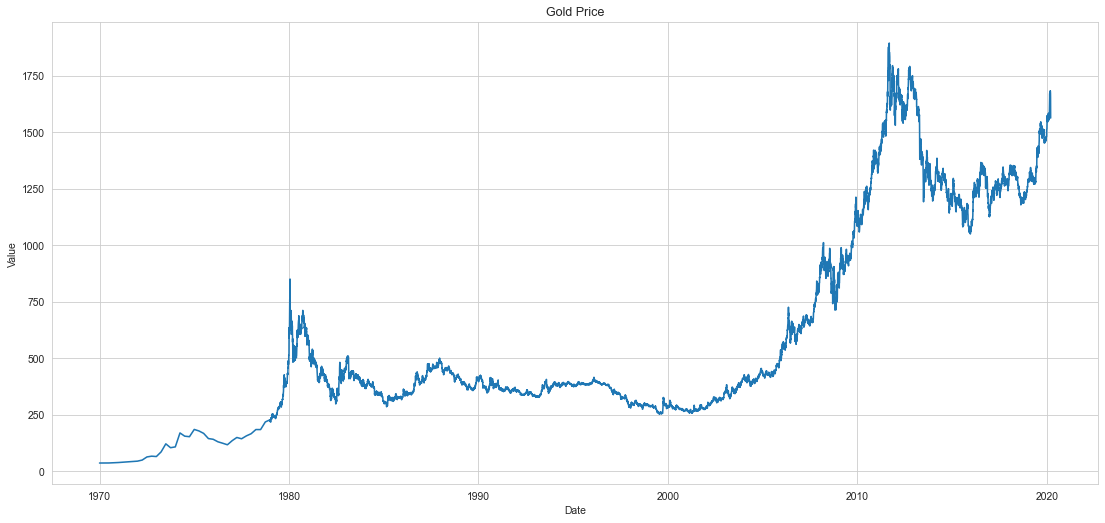

In [40]:
plt.figure(figsize = (18,8))
sns.lineplot(data=gold, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

### See Time Series Components (Level, Trend, Seasonality)

In [8]:
gold_eda = gold.copy()
gold_eda.set_index('Date', inplace=True)

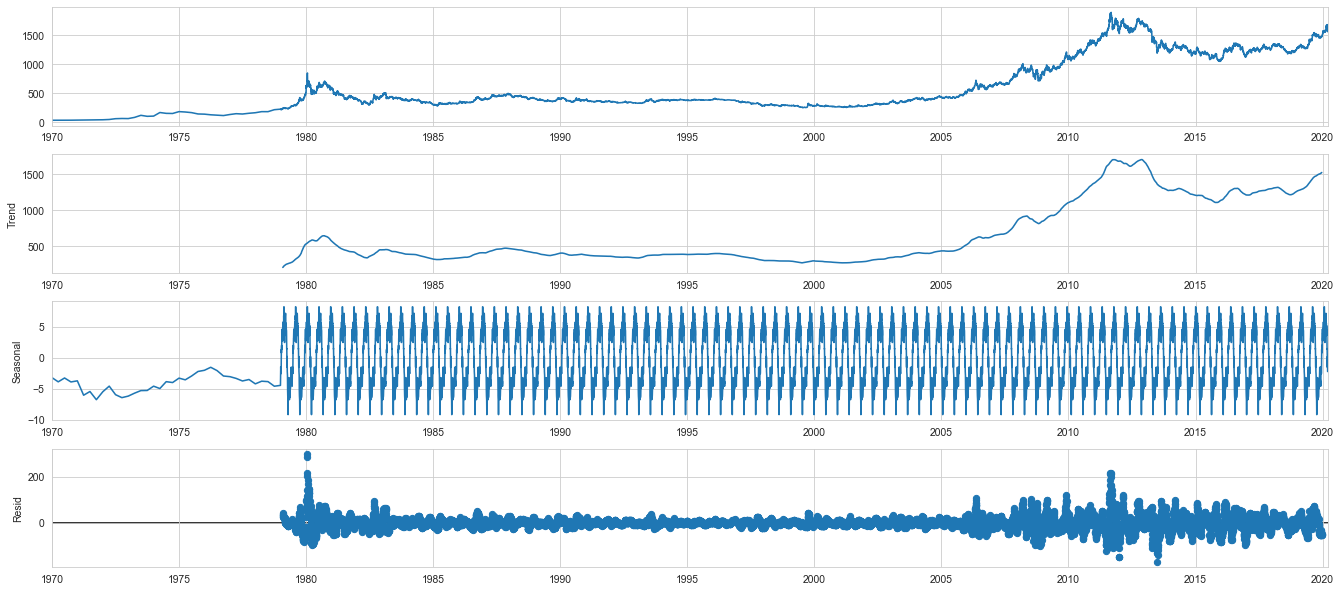

In [9]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

### Data Splitting
- I decide to split data into 75:25

In [10]:
X_train = gold[:8090]
X_test = gold[8090:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (8090, 2)
X_test Shape (2697, 2)


### Forecasting For Nine Months Ahead

In [11]:
X_train = X_train[['Date', 'Value']]
X_test = X_test[['Date', 'Value']]

X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)

In [12]:
index_9_months = pd.date_range(X_test.index[-1], freq='MS', periods=9)
index_9_months

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

### Define d Using ADF Test
- pvalue = 0.05

In [13]:
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(X_train,labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train)

ADF Test Statistic : 0.7111393941300093
p-value : 0.9900575735401028
#Lags Used : 36
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Indicating It Is Non-Stationary **


In [14]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -15.695627256339964
p-value : 1.4163027798506914e-28
#Lags Used : 35
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Data Is Stationary **


    I define d = 1

### Define p and q using PACF and ACF plot

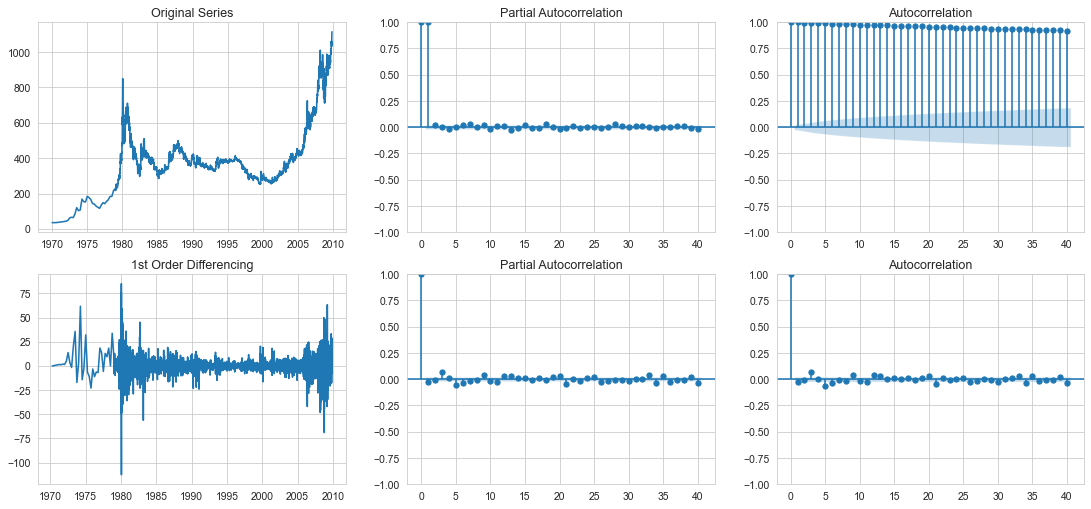

In [15]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train); axes[0, 0].set_title('Original Series')
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show()

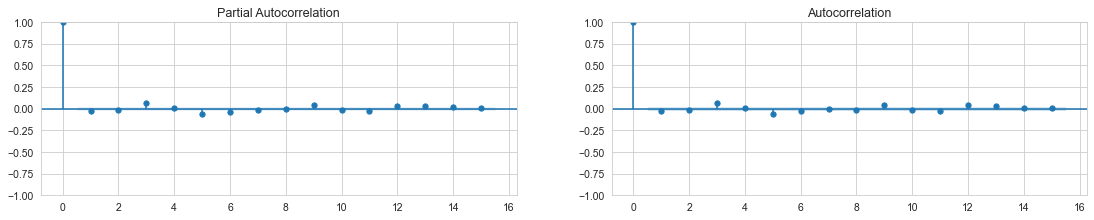

In [16]:
plt.rcParams.update({'figure.figsize':(18,3), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(X_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

    Based on PACF and ACF, I define p = 0 and q = 0

# MLP

## Basic Analytics :

 <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [ ]:
# inspect first 15 rows of data
gold.head(15)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4
5,1971-04-01,38.9
6,1971-07-01,40.1
7,1971-10-01,42.0
8,1972-01-03,43.5
9,1972-04-03,48.3


In [ ]:
# compute dtype
for column in gold.columns:
    print(f"The data type for '{column}' column is: {gold[column].dtype}")

The data type for 'Date' column is: datetime64[ns]
The data type for 'Value' column is: float64


In [ ]:
# compute descriptive statistics
gold.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


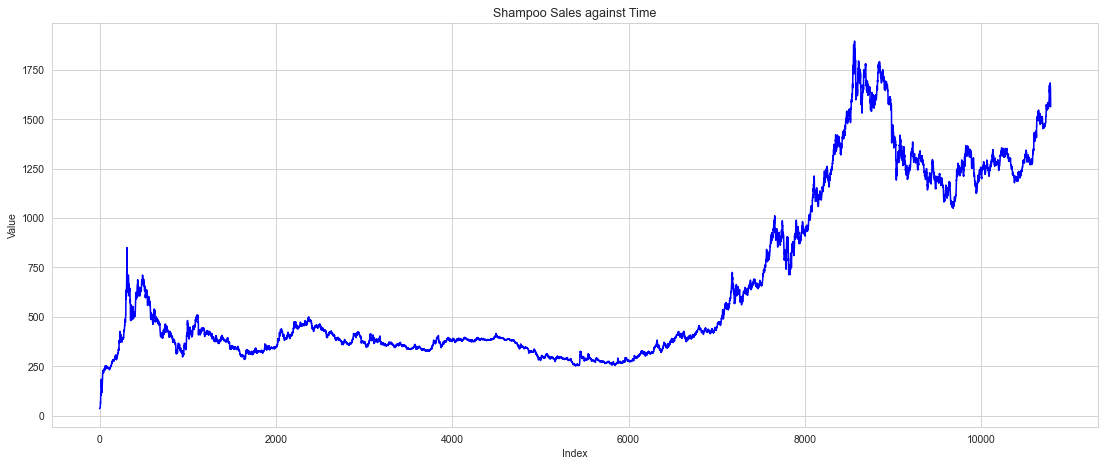

In [ ]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    gold['Value'],
    color='blue', label='Data');

In [23]:
# split dataset
df_train, df_test = train_test_split(gold, train_size=0.7, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 7550
The length of test dataset is: 3237


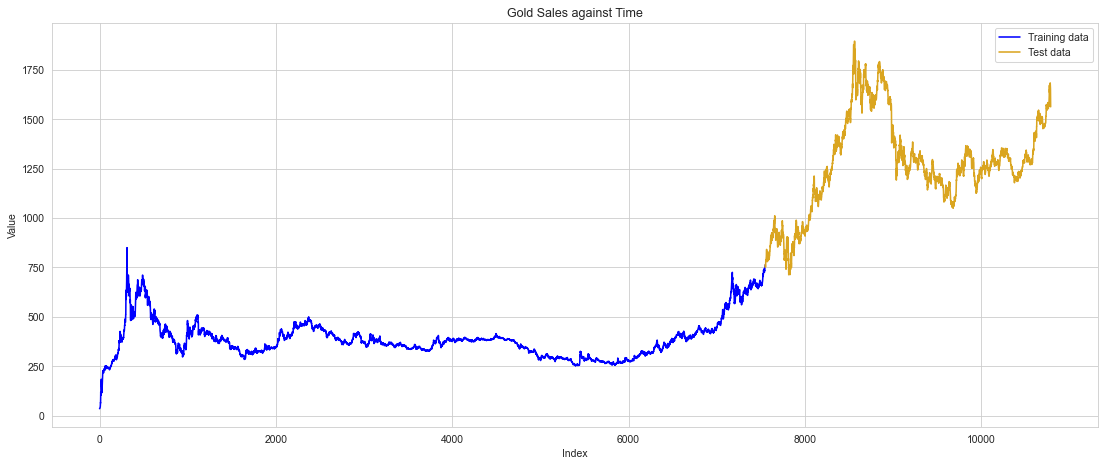

In [24]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['Value'],
    color='blue', label='Training data');
ax.plot(
    df_test['Value'],
    color='goldenrod', label='Test data')
ax.legend();

In [25]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['Value'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['Value'].values.reshape(-1,1))

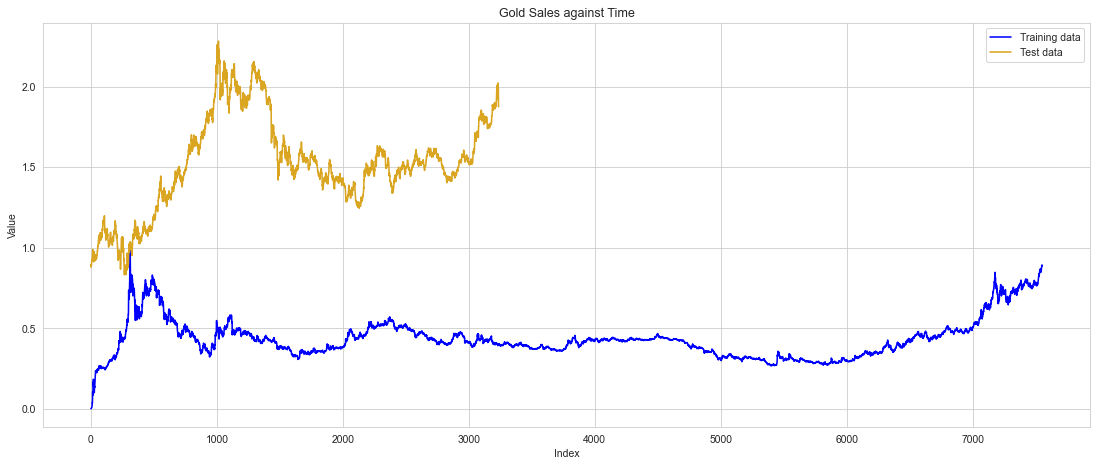

In [26]:
# test de scaler:
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    train_scaled,
    color='blue', label='Training data');
ax.plot(
    test_scaled ,
    color='goldenrod', label='Test data')
ax.legend();

## Model Development

In [27]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
# 3 est la taille de fenetre pour le sequensage ( no underfitting ni overfitting c'est juste la valeur q'on prend pour predire par exemple 3 jours pour predire la temperature )
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 7547
Total samples for y train: 7547
Total samples for X test: 3234
Total samples for y test: 3234


In [28]:
class GoldDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    # Pytorch/ tensorflow optimise le calcul en decoupant les données en des vecteur float tensor(matrice) c-a-d les mettre en ptit portions pour accelerer la processus 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [29]:
# declare batch size (4 input)
batch_size = 4

# convert into Dataset using customized class
train_Dataset = GoldDataset(X_sequence_train, y_sequence_train)
test_Dataset = GoldDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)
#==> convertir puis charger les données
# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

In [30]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

In [31]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)
# MLP multilayer perceptor
# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)


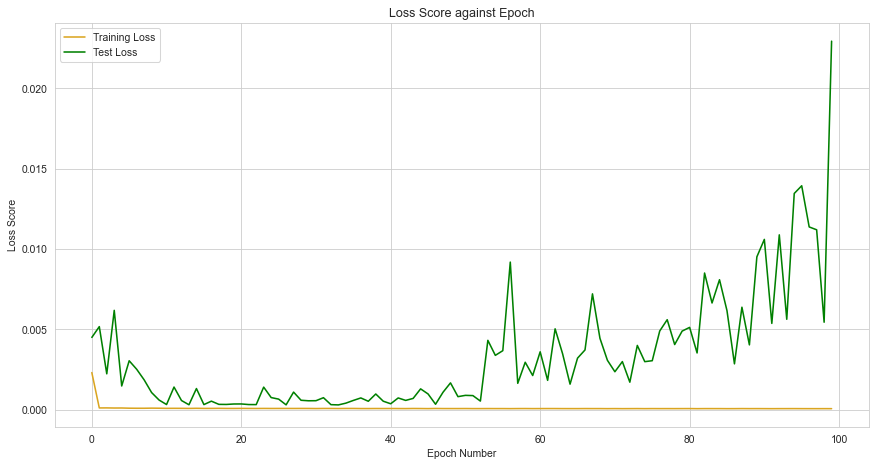

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

## Evaluation

There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE. 

In [34]:
#on doit reinitialiser les df_train et df_test
df_train, df_test = train_test_split(gold, train_size=0.7, shuffle=False)


# model predictions
model.eval()
predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.Value, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 123.40190065394593


7553      733.328728
7554      737.770427
7555      737.889816
7556      746.196861
7557      757.099390
            ...     
10782    1489.654798
10783    1478.370980
10784    1462.038801
10785    1461.270978
10786    1390.082945
Name: preds, Length: 3234, dtype: float64


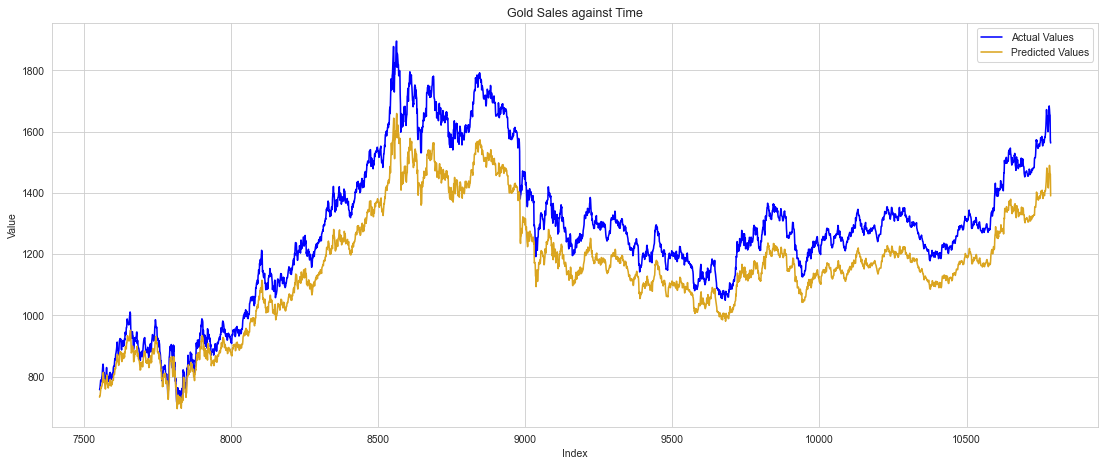

In [35]:
# print prediction results
### BEGIN SOLUTION
print(df_test['preds'])

### END SOLUTION

# plot time plot for predictions and ground truth 
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['Value'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();

### END SOLUTION